in this notebook, FEF model in [Pesaran, M. Hashem; Zhou, Qiankun (2014): Estimation of Time-invariant Effects in Static Panel Data Models] (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2493312) is applied to estimate the effect of time-invariant variables, altruism, in the panel data.

this notebook is structured as followed:
- examine missing value through plots
- implementation of FEF
- generate kernel density estimate plot using residual from FEF model
- conditional regression on sets that are more likely to make humanitarian donations 

I wrote this in Stata first to ensure the correctness of applying statistic models, then writing this again in Python for the completeness of the project and to practice.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from auxiliary import Quick_reg
import zipfile
import missingno as msno

pd.set_option('display.max_columns', 500)

sns.set_theme(style="ticks")

In [ ]:
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [2]:
long = pd.read_csv('data/result_long.csv')

### examine missing value

In [3]:
gni = Quick_reg(['gni'])
ma = gni.clean(long)
ma.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1368 entries, ('AFG', 2003) to ('ZWE', 2020)
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   funding_capita    874 non-null    float64
 1   altruism          1368 non-null   float64
 2   posrecip          1368 non-null   float64
 3   risktaking        1368 non-null   float64
 4   patience          1368 non-null   float64
 5   trust             1368 non-null   float64
 6   negrecip          1368 non-null   float64
 7   income_type       1368 non-null   object 
 8   region            1368 non-null   object 
 9   oecd              1368 non-null   int64  
 10  g20               1368 non-null   int64  
 11  oda_int           1368 non-null   int64  
 12  aid               1368 non-null   int64  
 13  demo_electoral    912 non-null    float64
 14  demo_gov          912 non-null    float64
 15  demo_participate  912 non-null    float64
 16  demo_culture      912

### graoh for examine missing value
- democratic have no data for 2007, 2009 and before 2006 simply bcs the assessment wasn't held in those years
- relatively small amount of missing value in govexpense & gdpcapita
- gni have large number of missing value for non-specific reason

<AxesSubplot:>

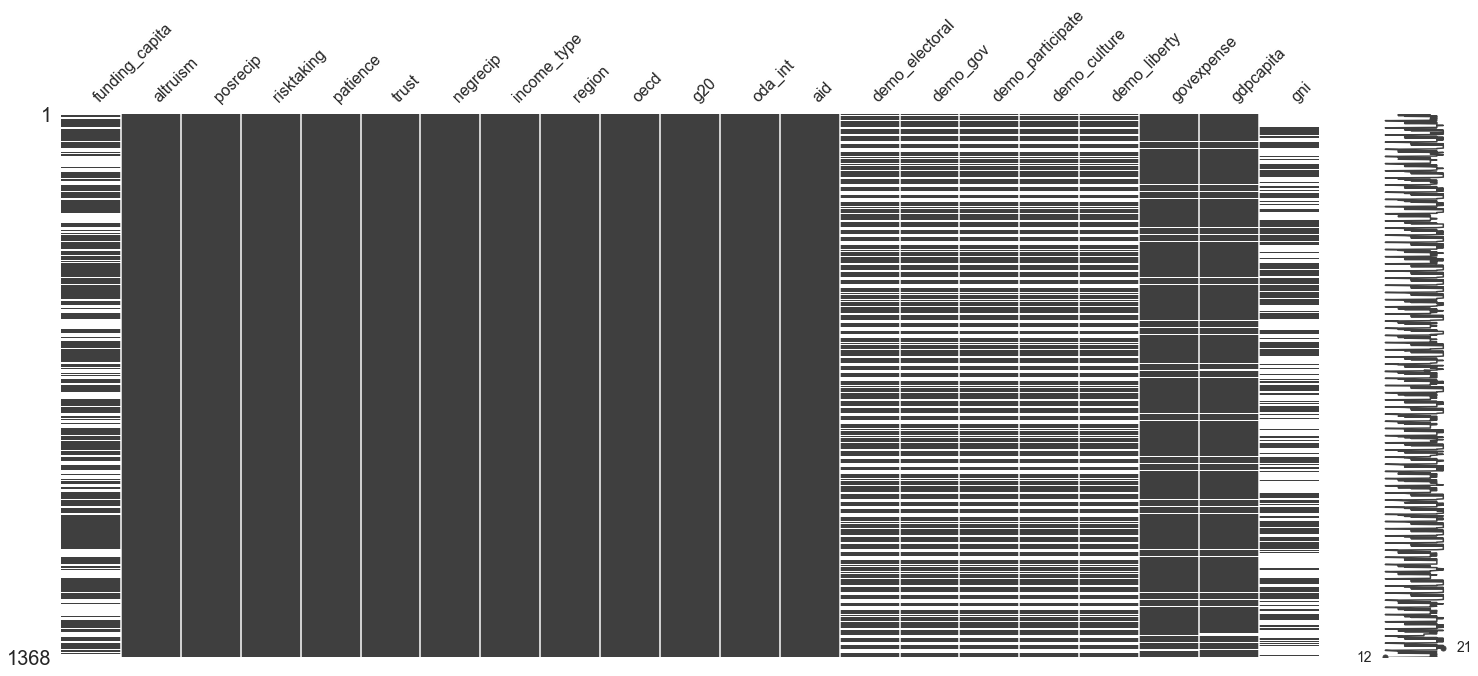

In [4]:
msno.matrix(ma)

### plot the relationship between y and x by missing gini index or not
### doesn't looks like missing at completely random
 in this notebook the result include and exclude gini index would be seperated, it's an highly influential factors based on past research, but the large number of missing value is not MACR and may causes bias. 

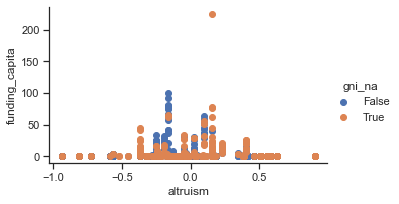

In [5]:
long_select_gni_na = ma.assign(gni_na=ma.gni.isnull())
fg = sns.FacetGrid(data=long_select_gni_na, hue='gni_na', aspect=1.61)
fg.map(plt.scatter, 'altruism', 'funding_capita').add_legend()


# FEF
### step 1: panel fixed effect model 
### step 2: predict residual by country
### step 3: regress time-invariant variables on residual
then plot out residual in step 3, to see how the model fits

### with Gini index


                            OLS Regression Results                            
Dep. Variable:                    res   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.9548
Date:                Tue, 05 Jan 2021   Prob (F-statistic):              0.525
Time:                        16:15:23   Log-Likelihood:                -200.15
No. Observations:                  59   AIC:                             438.3
Df Residuals:                      40   BIC:                             477.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
altrui

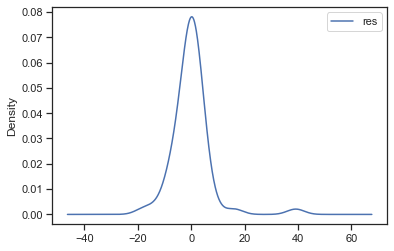

In [6]:
# with gni
df_dummy =  gni.step2_add_dummy(ma)
gni.result(df_dummy)

### without Gini index


                            OLS Regression Results                            
Dep. Variable:                    res   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.9784
Date:                Tue, 05 Jan 2021   Prob (F-statistic):              0.499
Time:                        16:15:29   Log-Likelihood:                -247.01
No. Observations:                  74   AIC:                             534.0
Df Residuals:                      54   BIC:                             580.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
altrui

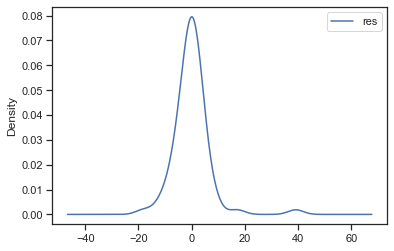

In [7]:
#without gni
Quick_reg([]).auto_reg(long)

### condition on possible set that is more likely to donate

`income_type_High income` == 1
                            OLS Regression Results                            
Dep. Variable:                    res   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                 -0.383
Method:                 Least Squares   F-statistic:                    0.4855
Date:                Tue, 05 Jan 2021   Prob (F-statistic):              0.901
Time:                        16:15:35   Log-Likelihood:                -98.789
No. Observations:                  27   AIC:                             227.6
Df Residuals:                      12   BIC:                             247.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

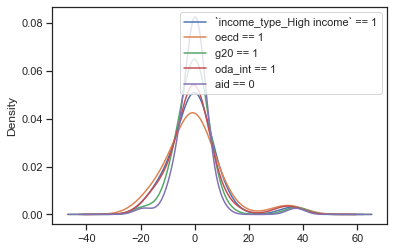

In [8]:
query = ['`income_type_High income` == 1',
        'oecd == 1',
        'g20 == 1',
        'oda_int == 1',
        'aid == 0']

for i in query:
    df_query = df_dummy.query(i)
    print(i)
    gni.label = i
    result = gni.result(df_query)
